In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv("C:/Users/lenovo/Desktop/乳腺癌诊断数据集/wisc_bc_data.csv")

In [2]:
data.drop("id",axis = 1,inplace=True)
data['diagnosis'] = data['diagnosis'].replace(['M','B'],[1, 0])

array([[<Axes: title={'center': 'diagnosis'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>],
       [<Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'concavity_se'}>,
        <Axes: title={'center': 'symmetry_se'}>],
       [<Axes: title={'center': 'fractal_dimension_se'}>,
        <Axes: title={'center': 'radius_worst'}>,
        <Axes: title={'center': 'texture_worst'}>,
        <Axes: title={'center': 'smoothness_worst'}>],
       [<Axes: title={'center': 'concavity_worst'}>,
        <Axes: title={'center': 'symmetry_worst'}>,
        <Axes: title={'center': 'fractal_dimension_worst'}>, <Axes: >]]

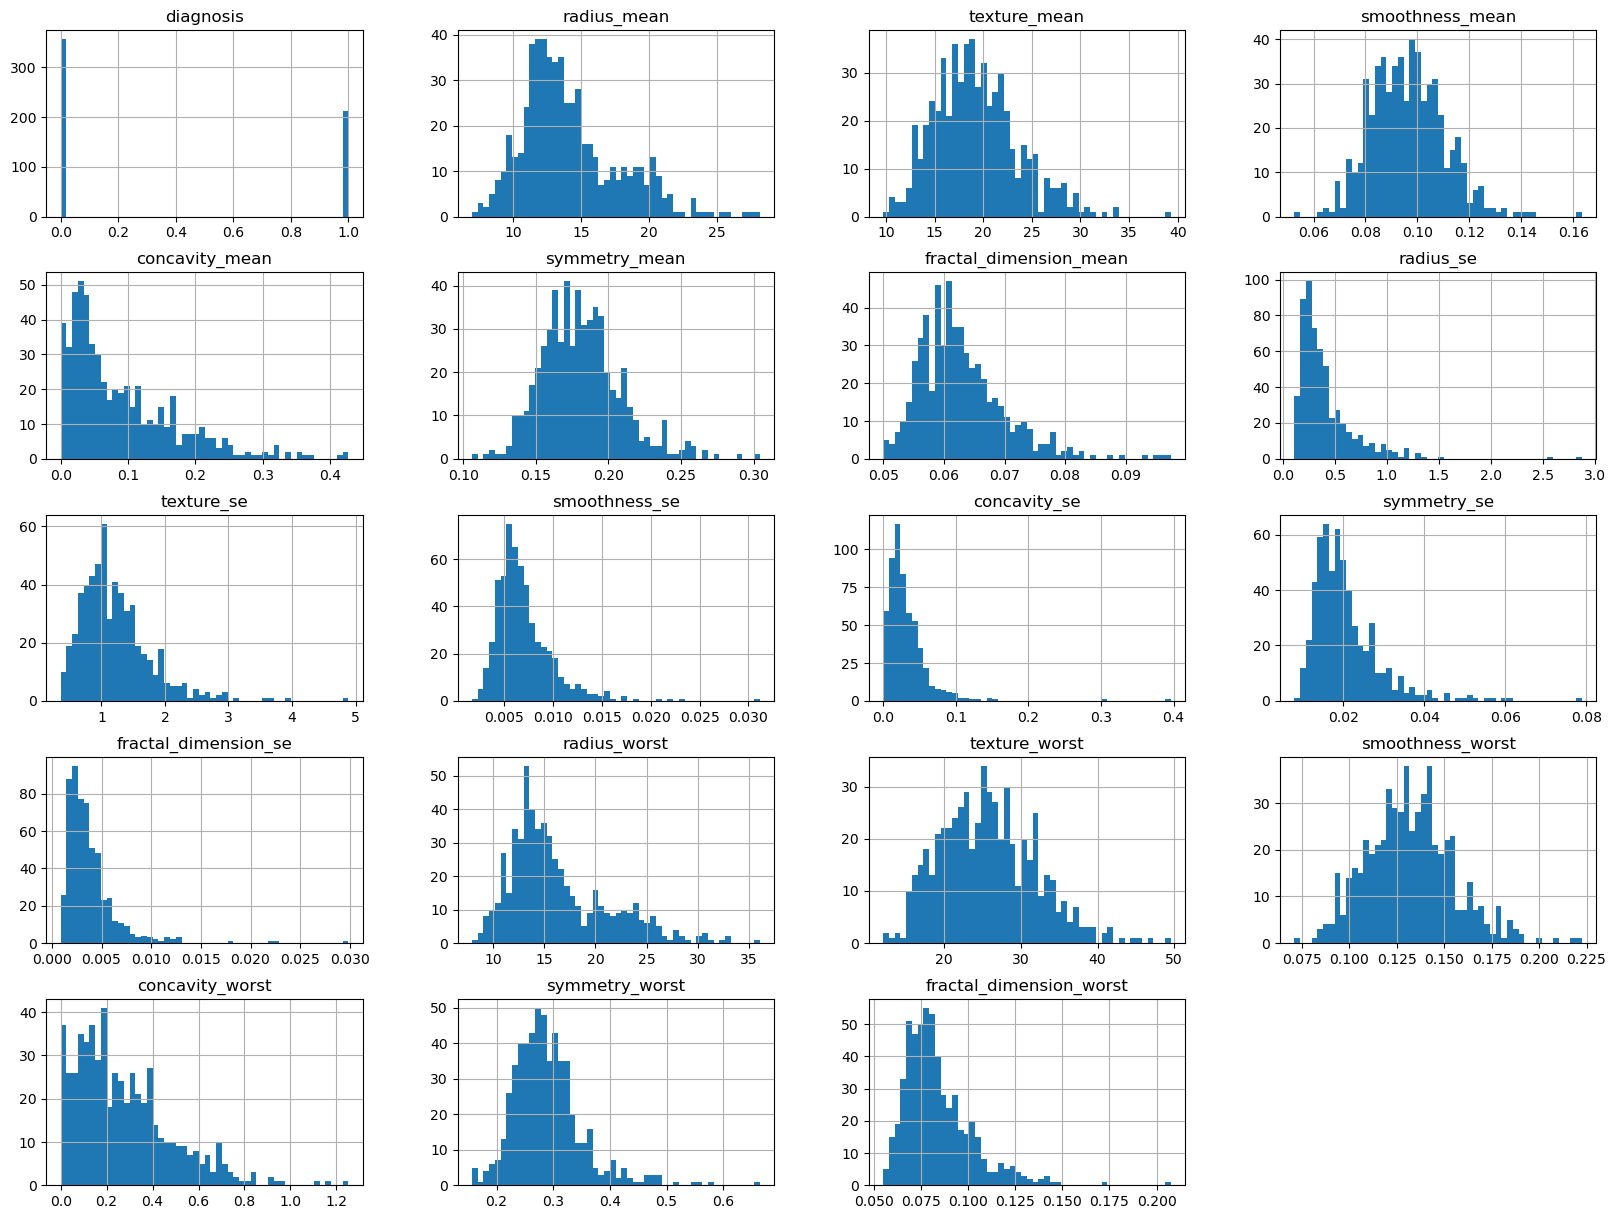

In [3]:
columns_to_drop = ["perimeter_mean", "perimeter_se", "perimeter_worst", "area_mean", "area_se", "area_worst", "compactness_mean", "compactness_se", "compactness_worst", "concave points_mean", "concave points_se", "concave points_worst"]
data_new = data.drop(columns_to_drop, axis=1)
data_new.hist(bins=50,figsize=(20,15))

In [4]:
y = data_new['diagnosis']
x = data_new.drop(['diagnosis'], axis=1)

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x.values, y.values, test_size=0.2, random_state=421)

In [5]:
param_grid = {'max_depth': range(1, 28)}
clf = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(xtrain, ytrain)
print("本次交叉验证得到的最优深度:", grid_search.best_params_['max_depth'])

本次交叉验证得到的最优深度: 16


过程中发现每次得到的最优深度不同。

1. 参数范围的选择：在网格搜索中，通过定义参数范围来搜索最优深度。不同的参数范围选择可能导致不同的最优深度。

2. 交叉验证的随机性：网格搜索使用交叉验证来评估模型的性能。交叉验证通常会随机地将数据集划分为训练集和验证集，因此每次运行时使用的训练集和验证集可能不同，从而导致不同的最优深度。

3. 模型的随机性：决策树算法中的一些实现可能具有随机性，例如在选择分裂特征时的随机选择。这种随机性可能导致每次运行时得到不同的最优深度。

因此，每次运行代码得到的最优深度不同，这里选择了15作为最优深度。

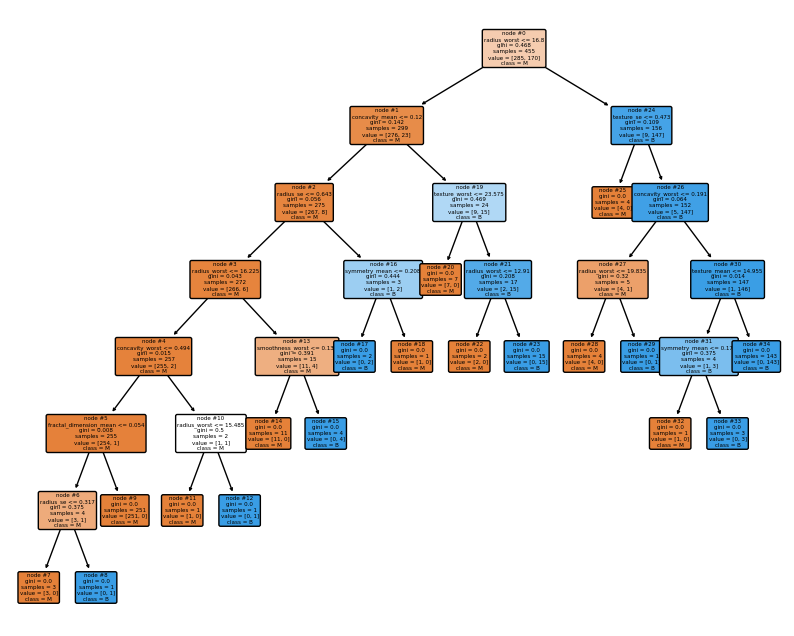

In [6]:
clf = tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(xtrain, ytrain)
feature_names = list(x.columns)
plt.figure(figsize=(10, 8))
tree.plot_tree(clf, filled=True, feature_names=feature_names, class_names=['M', 'B'], rounded=True, fontsize=4, node_ids=True)
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.show()

In [7]:
def confusion_matrix(y_true, y_pred, labels):
    num_labels = len(labels)
    matrix = [[0] * num_labels for _ in range(num_labels)]
    for true_label, pred_label in zip(y_true, y_pred):
        matrix[true_label][pred_label] += 1
    return matrix

In [8]:
y_pred = clf.predict(xtest)
cm = confusion_matrix(ytest, y_pred,['1','0'])
print("混淆矩阵：")
print(cm)
print(clf.score(xtest,ytest))

混淆矩阵：
[[68, 4], [10, 32]]
0.8771929824561403


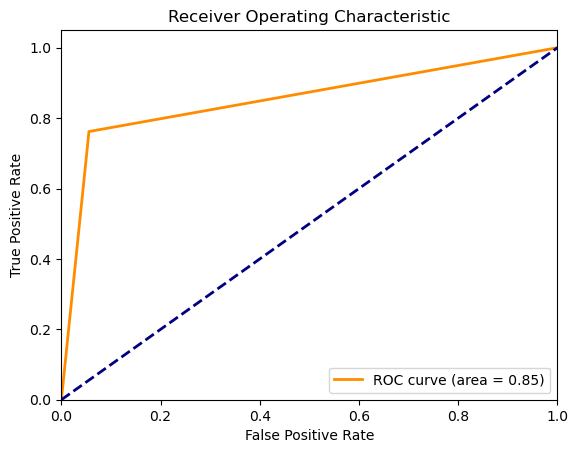

In [9]:
y_pred_proba = clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
class Node:
    def __init__(self, feature=None, threshold=None, label=None, left=None, right=None):
        self.feature = feature  # 用于划分的特征索引
        self.threshold = threshold  # 划分阈值
        self.label = label  # 叶节点的类别标签
        self.left = left  # 左子树
        self.right = right  # 右子树

class Decision_Tree_Classifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # 决策树的最大深度
        self.tree = None  # 决策树的根节点

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def predict(self, X):
        y_pred = []
        for sample in X:
            y_pred.append(self._predict_sample(sample))
        return np.array(y_pred)
    
    def _build_tree(self, X, y, depth):
        # 停止条件：1. 所有样本属于同一类别；2. 达到最大深度；3. 没有可划分的特征
        if len(np.unique(y)) == 1 or depth == self.max_depth or len(X[0]) == 0:
            return Node(label=np.argmax(np.bincount(y)))

        best_feature, best_threshold = self._find_best_split(X, y)
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth+1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth+1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _find_best_split(self, X, y):
        best_gini = 1
        best_feature = None
        best_threshold = None

        for feature in range(len(X[0])):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                gini = self._gini_index(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_index(self, y_left, y_right):
        n_left = len(y_left)
        n_right = len(y_right)

        gini_left = 1 - np.sum([(np.sum(y_left == c) / n_left) ** 2 for c in np.unique(y_left)])
        gini_right = 1 - np.sum([(np.sum(y_right == c) / n_right) ** 2 for c in np.unique(y_right)])

        return (n_left * gini_left + n_right * gini_right) / (n_left + n_right)

    def _predict_sample(self, sample):
        node = self.tree
        while node.left and node.right:
            if sample[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.label

In [11]:
clf = Decision_Tree_Classifier(max_depth=15)
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
cm = confusion_matrix(ytest, y_pred, ['1', '0'])
correct = np.count_nonzero((y_pred == ytest) == True)
print("混淆矩阵：")
print(cm)
print("Accuracy is: %.4f" % (correct/len(xtest)))

混淆矩阵：
[[69, 3], [8, 34]]
Accuracy is: 0.9035
